# TOC

__Chapter 5 - Deep learning for computer vision__

1. [Import](#Import)
1. [CNN introduction](#CNN-introduction)
    1. [MNIST - Getting the data](#MNIST-Getting-the-data)
    1. [The model](#The-model)
        1. [Conv2d](#Conv2d)
        1. [Pooling](#Pooling)
        1. [Nonlinear activation - ReLU](#Nonlinear-activation-ReLU)
        1. [View](#View)
        1. [Linear layer](#Linear-layer)
    1. [Training the model](#Training-the-model)
1. [Classifying dogs and cats – CNN from scratch](#Classifying-dogs-and-cats–CNN-from-scratch)
1. [Classifying dogs and cats using transfer learning](#Classifying-dogs-and-cats-using-transfer-learning)
    1. [Creating and exploring a VGG16 model](#Creating-and-exploring-a-VGG16-model)
        1. [Freezing the layers](#Freezing-the-layers)
        1. [Fine-tuning VGG16](#Fine-tuning-VGG16)
    1. [Training the VGG16 model](#Training-the-VGG16-model)
1. [Calculating pre-convoluted features](#Calculating-pre-convoluted-features)
1. [Understanding what a CNN model learns](#Understanding-what-a-CNN-model-learns)
    1. [Visualizing outputs from intermediate layers](#Visualizing-outputs-from-intermediate-layers)
1. [Visualizing weights of the CNN layer](#Visualizing-weights-of-the-CNN-layer)

# Import

<a id = 'Import'></a>

In [1]:
# standard libary and settings
import os
import sys
import importlib
import itertools
from PIL import Image
from glob import glob
import warnings

warnings.simplefilter("ignore")
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:95% !important; }</style>"))

# data extensions and settings
import numpy as np

np.set_printoptions(threshold=np.inf, suppress=True)
import pandas as pd

pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.options.display.float_format = "{:,.6f}".format

# pytorch tools
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.autograd import Variable
from torchvision import datasets, models, transforms

# visualization extensions and settings
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

# custom extensions and settings
sys.path.append("/home/mlmachine") if "/home/mlmachine" not in sys.path else None
sys.path.append("/home/prettierplot") if "/home/prettierplot" not in sys.path else None

import mlmachine as mlm
from prettierplot.plotter import PrettierPlot
import prettierplot.style as style

# CNN introduction
CNNs offer an alternative to fully connected networks and are used with great results in image classification. The general architecture of a CNN model has the potential to reduce the total number of weights in the model, and more importantly, using convolutions to evaluate images helps to extract information form the spatial arrangement of pixels that make up the images.



<a id = 'CNN introduction'></a>

## MNIST - Getting the data



<a id = 'MNIST-Getting-the-data'></a>

In [2]:
# load data
transformation = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
)

train_dataset = datasets.MNIST(
    "/main/tmp/", train=True, transform=transformation, download=True
)
test_dataset = datasets.MNIST(
    "/main/tmp/", train=False, transform=transformation, download=True
)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

In [3]:
# dataset shape
train_loader.dataset.data.shape

torch.Size([60000, 28, 28])

In [4]:
# plot class : idx dictionary
train_loader.dataset.class_to_idx

{'0 - zero': 0,
 '1 - one': 1,
 '2 - two': 2,
 '3 - three': 3,
 '4 - four': 4,
 '5 - five': 5,
 '6 - six': 6,
 '7 - seven': 7,
 '8 - eight': 8,
 '9 - nine': 9}

In [5]:
# view raw data of first image
train_loader.dataset.data[0]

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,
          18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   

In [6]:
# plot sample image
def plot_img(image):
    image = image.numpy()
    mean = 0.1307
    std = 0.3081
    image = (mean * image) + std
    plt.imshow(image, cmap="gray")


# sample_data = next(iter(train_loader.dataset.data))
sample_data = iter(train_loader.dataset.data)

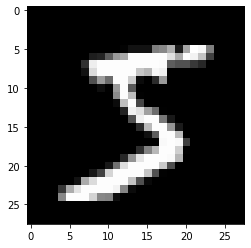

In [7]:
# plot 1st image
plot_img(next(sample_data))

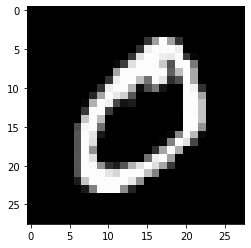

In [8]:
# plot second image...
plot_img(next(sample_data))

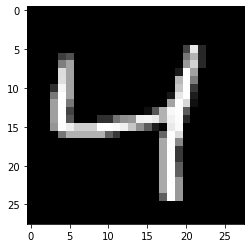

In [9]:
# ...plot third image...
plot_img(next(sample_data))

## The model

This first implementation will be built from scratch. This model will involve several different layers, including: Conv2d, MaxPool2d, Rectified linear unit (ReLU), View and Linear layer.

The model will have the following sequence:

- Conv2d
- MaxPool2d
- ReLU
- Conv2d
- Dropout
- MaxPool2d
- ReLU
- View
- FC
- ReLU
- Dropout
- FC
- Log_softmax


<a id = 'The-model'></a>

In [10]:
# implementation of strucutre described above
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

### Conv2d

Conv2d applies a convolutional filter to the MNIST images. This operation can be thought of moving a window across the pixel grid, completing its evaluation at each step. As a simple example, we can illustrate a simple Conv1d operation with a small filter (kernel) operating on a length 7 tensor.

The kernel has the values $[-0.5209, -0.0147, -0.4281]$

The input tensor is $[0.2286, 2.4488, -0.9498, -0.5330, -0.6791, -0.6535, 0.6437]$

The first output is:

$$
(-0.5209 \times 0.2286) + (-0.0147 \times -0.147) + (-0.4281 \times -0.9498) = 0.2514
$$

The last output (totaling 5) is:

$$
(-0.5209 \times -0.6791) + (-0.0147 \times -0.6535) + (-0.4281 \times -0.6437) = 0.0878
$$

The stride parameter determines the number of units that the kernel window moves forward after completing a convolution. In the example above, the stride is 1. 


<a id = 'Conv2d'></a>

In [11]:
# simple convolution operation
conv = nn.Conv1d(1, 1, 3, bias=False)
sample = torch.randn(1, 1, 7)

# print kernel weights and sampe tensor
print(conv.weight)
print(sample)

# print the result of convolution
conv(torch.autograd.Variable(sample))

Parameter containing:
tensor([[[ 0.3921, -0.1069,  0.1240]]], requires_grad=True)
tensor([[[-2.2080, -0.0573,  0.6981, -0.7831,  0.5597, -1.4876,  1.8058]]])


tensor([[[-0.7730, -0.1942,  0.4268, -0.5514,  0.6025]]],
       grad_fn=<SqueezeBackward1>)

If the stride was set to 2, the filter would move by 2 positions, which would also result in a smaller output. Even a stride of 1 will reduce a size 7 1-d tensor to size 5. In order to ensure that the image size is not reduced, we can use padding, which adds additional zeros to allow the kernel sufficient room to move such that the output is the same size as the input.

The weights in the kernel are initialized randomly and then gradient descent and backpropagation tune kernel values. The learned kernels identify different features, such as lines, curves, and specific object, such as eyes.

Conv2d accepts a parameter kernel_size, which controls the size of the kernel. Common values are 1, 3, 5, and 7. The larger the kernel size, the larger the area that a filter can cover as it slides across the image.


### Pooling

Pooling layers commonly follow convolutional layers, because these layers have the benefit of reducing the size of the ocnvolutional layer outputs and the feature maps. Pooling fosters two benefits: first, it reduces the size of data to process, and second, it has a way of forcing the algorithm to not focus on small changes in the position of an object in an image. 

We will explore how ooling working using MaxPool2d. Similar to convolutional kernels, pooling accepts parameters for kernel size and stride, but differs in that it does not have an weights. Rather, it acts on the data generated by each filter from the previous layer. If the kernel size of a pooling operation is 2 x 2, then it considers a pixel grid of that size in an image and chooses the maximum value out of that 2 x 2 window. Similarly, average pooling average all values within the 2 x 2 kernel window and returns the average of the four values.

<a id = 'Pooling'></a>

### Nonlinear activation - ReLU

It is best practice to use a nonlinear layer after convolution or pooling is applied. Many of the most successful models use ReLU or some variation of ReLU. Whichever function is used, it gets applied to each element of the feature maps. In the case of ReLU, all negative values are set to 0 and non-negative values retain the same value.

<a id = 'Nonlinear-activation-ReLU'></a>

### View

A view layer flattens a matrix into a 1-d tensor. If our data has the shape 32 x 1 x 28 x 28, meaning we have a batch size of 32 images, where each image is a 28 by 28 pixel grid with one color channel, we need to be careful when flattening the data

```python
x.view(-1, 320)
```

The -1 in the view function above is an instruction to avoid flattening the data on the first dimension. Without this, the 32 images would be mixed together.



<a id = 'View'></a>

### Linear layer

At this point in the architecture, the data has been converted from a 2-d tensor to a 1-d tensor, and is then passed into a linear layer, followed by a nonlinear activation function. This example has two linear layer - the first is following by a ReLU nonlinear activation layer, and the second is followed by a log_softmax layer, which predicts which digit is contained in each image.

<a id = 'Linear layer'></a>

## Training the model

This approach implements different logic for training and validation. In the train mode, dropout removes a set percentage of values, which does not happen in the validation phase. Also, we calculate gradients and change the model's parameter values, but this backpropagation step is not needed in the validation phase.

<a id = 'Training-the-model'></a>

In [12]:
# load data
transformation = transforms.Compose([transforms.ToTensor()
                                    ,transforms.Normalize((0.1307,), (0.3081,))])

train_dataset = datasets.MNIST('/main/tmp/', train = True, transform = transformation, download = True)
test_dataset = datasets.MNIST('/main/tmp/', train = False, transform = transformation, download = True)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 32, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 32, shuffle = True)

# for batch_idx, data in enumerate(train_loader.dataset):
for batch_idx, (data, target) in enumerate(train_loader):
    print(batch_idx)
    print(data)
    #     print(target)
    break

0
tensor([[[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          ...,
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]],


        [[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          ...,
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]],


        [[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4

In [13]:
# function for training the model
def fit(epoch, model, data_loader, phase="training", volatile=False):
    if phase == "training":
        model.train()
    if phase == "validation":
        model.eval()
        volatile = True
    running_loss = 0.0
    running_correct = 0

    for batch_idx, (data, target) in enumerate(data_loader):
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile), Variable(target)
        if phase == "training":
            optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)

        running_loss += F.nll_loss(output, target, reduction="sum").data.item()
        preds = output.data.max(dim=1, keepdim=True)[1]
        running_correct += preds.eq(target.data.view_as(preds)).cpu().sum()
        if phase == "training":
            loss.backward()
            optimizer.step()

    loss = running_loss / len(data_loader.dataset)
    accuracy = 100.0 * running_correct / len(data_loader.dataset)

    print(
        "{0} loss is {1} and {0} accuracy is {2}/{3} {4}".format(
            phase, loss, running_correct, len(data_loader.dataset), accuracy
        )
    )
    return loss, accuracy

In [14]:
# run model for 20 epochs
model = Net()
if torch.cuda.is_available():
    model.cuda()

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
train_losses, train_accuracy = [], []
val_losses, val_accuracy = [], []
for epoch in range(1, 10):
    epoch_loss, epoch_accuracy = fit(epoch, model, train_loader, phase="training")
    val_epoch_loss, val_epoch_accuracy = fit(
        epoch, model, test_loader, phase="validation"
    )
    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

training loss is 0.6551883478919664 and training accuracy is 47442/60000 79
validation loss is 0.13073587970733644 and validation accuracy is 9602/10000 96
training loss is 0.29842912548383077 and training accuracy is 54618/60000 91
validation loss is 0.08818658404350281 and validation accuracy is 9715/10000 97
training loss is 0.2405530866543452 and training accuracy is 55732/60000 92
validation loss is 0.07788408356904984 and validation accuracy is 9752/10000 97
training loss is 0.2145130447645982 and training accuracy is 56205/60000 93
validation loss is 0.0634393702030182 and validation accuracy is 9798/10000 97
training loss is 0.19342437677383423 and training accuracy is 56544/60000 94
validation loss is 0.05648748519420624 and validation accuracy is 9824/10000 98
training loss is 0.18383040647705395 and training accuracy is 56770/60000 94
validation loss is 0.050854619145393375 and validation accuracy is 9834/10000 98
training loss is 0.1716128733098507 and training accuracy is 

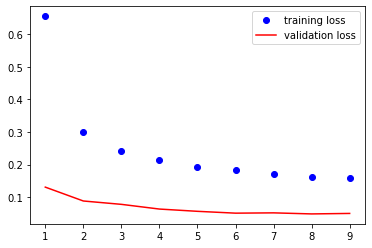

In [15]:
# plot training and test loss
plt.plot(range(1, len(train_losses) + 1), train_losses, "bo", label="training loss")
plt.plot(range(1, len(val_losses) + 1), val_losses, "r", label="validation loss")
plt.legend()

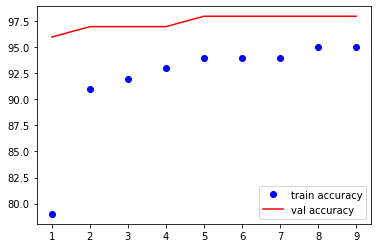

In [16]:
# plot accuracy
plt.plot(
    range(1, len(train_accuracy) + 1), train_accuracy, "bo", label="train accuracy"
)
plt.plot(range(1, len(val_accuracy) + 1), val_accuracy, "r", label="val accuracy")
plt.legend()

# Classifying dogs and cats – CNN from scratch

The input dimensions for the first layer is 256 by 256

<a id = 'Classifying-dogs-and-cats–CNN-from-scratch'></a>

In [33]:
# load images using the ImageFolder class
simple_transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)
train_dataset = datasets.ImageFolder("/main/tmp/DogsVsCats/trainSubset", simple_transform)
valid_dataset = datasets.ImageFolder("/main/tmp/DogsVsCats/validSubset", simple_transform)

In [40]:
# create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 128, shuffle = True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size = 128, shuffle = True)


In [41]:
#  model architecture
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(56180, 500)
        self.fc2 = nn.Linear(500, 50)
        self.fc3 = nn.Linear(50, 2)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc2(x))
        x = F.dropout(x, training=self.training)
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

In [42]:
# function for training the model
def fit(epoch, model, data_loader, phase="training", volatile=False):
    if phase == "training":
        model.train()
    if phase == "validation":
        model.eval()
        volatile = True
    running_loss = 0.0
    running_correct = 0

    for batch_idx, (data, target) in enumerate(data_loader):
        if is_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile), Variable(target)
        if phase == "training":
            optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)

        running_loss += F.nll_loss(output, target, size_average=False).data.item()
        preds = output.data.max(dim=1, keepdim=True)[1]
        running_correct += preds.eq(target.data.view_as(preds)).cpu().sum()
        if phase == "training":
            loss.backward()
            optimizer.step()

    loss = running_loss / len(data_loader.dataset)
    accuracy = 100.0 * running_correct / len(data_loader.dataset)

    print(
        "{0} loss is {1} and {0} accuracy is {2}/{3} {4}".format(
            phase, loss, running_correct, len(data_loader.dataset), accuracy
        )
    )
    return loss, accuracy

In [43]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# run model for 20 epochs
model = Net()
is_cuda = False
if is_cuda:
    model.cuda()

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
train_losses, train_accuracy = [], []
val_losses, val_accuracy = [], []
for epoch in range(1, 10):
    epoch_loss, epoch_accuracy = fit(epoch, model, train_loader, phase="training")
    val_epoch_loss, val_epoch_accuracy = fit(
        epoch, model, valid_loader, phase="validation"
    )
    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

/usr/local/lib/python3.6/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.6/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.6/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.6/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.6/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(r

training loss is 0.6936771240234375 and training accuracy is 1030/2000 51


/usr/local/lib/python3.6/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.6/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.6/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.6/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.6/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(r

validation loss is 0.6904739787851436 and validation accuracy is 1125/2001 56


/usr/local/lib/python3.6/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.6/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.6/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.6/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.6/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(r

training loss is 0.6906498432159424 and training accuracy is 1063/2000 53


/usr/local/lib/python3.6/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.6/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.6/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.6/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.6/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(r

validation loss is 0.6896835757993806 and validation accuracy is 1095/2001 54


/usr/local/lib/python3.6/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.6/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.6/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.6/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.6/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(r

training loss is 0.6903986263275147 and training accuracy is 1071/2000 53


/usr/local/lib/python3.6/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.6/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.6/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.6/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.6/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(r

validation loss is 0.6879772622843852 and validation accuracy is 1089/2001 54


/usr/local/lib/python3.6/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.6/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.6/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.6/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.6/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(r

training loss is 0.6854497394561767 and training accuracy is 1090/2000 54


/usr/local/lib/python3.6/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.6/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.6/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.6/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.6/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(r

validation loss is 0.685101195968788 and validation accuracy is 1125/2001 56


/usr/local/lib/python3.6/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.6/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.6/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.6/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.6/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(r

training loss is 0.6818285217285156 and training accuracy is 1121/2000 56


/usr/local/lib/python3.6/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.6/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.6/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.6/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.6/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(r

validation loss is 0.6802822324647003 and validation accuracy is 1150/2001 57


/usr/local/lib/python3.6/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.6/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.6/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.6/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.6/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(r

training loss is 0.67962380027771 and training accuracy is 1129/2000 56


/usr/local/lib/python3.6/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.6/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.6/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.6/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.6/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(r

validation loss is 0.6824144423454777 and validation accuracy is 1131/2001 56


/usr/local/lib/python3.6/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.6/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.6/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.6/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.6/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(r

training loss is 0.6755062751770019 and training accuracy is 1138/2000 56


/usr/local/lib/python3.6/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.6/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.6/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.6/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.6/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(r

validation loss is 0.6771472471466903 and validation accuracy is 1136/2001 56


/usr/local/lib/python3.6/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.6/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.6/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.6/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.6/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(r

training loss is 0.6739096412658692 and training accuracy is 1155/2000 57


/usr/local/lib/python3.6/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.6/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.6/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.6/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.6/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(r

validation loss is 0.6739555980371631 and validation accuracy is 1169/2001 58


/usr/local/lib/python3.6/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.6/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.6/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.6/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.6/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(r

training loss is 0.666793327331543 and training accuracy is 1188/2000 59


/usr/local/lib/python3.6/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.6/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.6/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.6/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.6/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(r

validation loss is 0.6669017900412587 and validation accuracy is 1204/2001 60


/usr/local/lib/python3.6/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [ ]:
# plot training and test loss
plt.plot(range(1, len(train_losses) + 1), train_losses, "bo", label="training loss")
plt.plot(range(1, len(val_losses) + 1), "r", label="validation loss")
plt.legend()

In [ ]:
# plot accuracy
plt.plot(
    range(1, len(train_accuracy) + 1), train_accuracy, "bo", label="train accuracy"
)
plt.plot(range(1, len(val_accuracy) + 1), val_accuracy, "r", label="val accuracy")
plt.legend()

> Remarks - The training loss decreases for every iteration, but the validation loss plateaus and then gets worse. As for accuracy, the training accuracy increases after every iteration but the validation accuracy plateaus at 75%. Clearly, the model is not generalizing  to unseen data.

# Classifying dogs and cats using transfer learning

Transfer learning is the ability to resuse a trained algorithm on a similar dataset without training it from scratch. Just as human do not completely relearn form scratch how to recognize new images, computer can utilize previous understanding on other tasks when learning new data.

The first few layers of a CNN model focus on smaller features, such as how a line or curve looks. It's not until the later layers that the CNN begins to look at more detailed features, such as eyes and fingers, and then the final layers seek to identify the exact category.

An algorithm called VGG16 is one of the earliest algorithms to find success in ImageNet competitions. More modern algorithms exist, but this algorithm is popular due to its comparative simplicity. The VGG16 architecture contains five VGG blocks. Each block is a set of conolution layers, a nonlinear activation function and a max-pooling function. All parameters are tuned to achieve state-of-the-art results for classifying 1,000 categories.

It is common practice to fine-tune only the last layers of the network, leaving the convolutional layers intact. We can do this because convolutional layers are mostly used for identifying shapes and features that are common across many image identificaiton problems.

<a id = 'Classifying-dogs-and-cats-using-transfer-learning'></a>

## Creating and exploring a VGG16 model

PyTorch includes several pre-trained model in the torchvision library. Below, we can see that the VGG16 model contains two sequential models: features and classifier. We are going to freeze the layers in the features sequential model and tune the layers in the classifier sequential model.

<a id = 'Creating-and-exploring-a-VGG16-model'></a>

In [47]:
# load VGG16 model and review architecture
from torchvision import models

vgg = models.vgg16(pretrained=True)
print(vgg)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [02:54<00:00, 3165349.22it/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

### Freezing the layers

We will be freezing all of the layers in the features model. This is the model that contains the convolutional block. Freezing the weights in these layers has the effect of preventing the weights in the layers from being trained further than they already have been. Utilizing the "knowledge" that has already contributed to the calibration of these weights is the essence of transfer learning. This can be done simply by turning of the gradient component of the features model parameters:

```python
for param in vgg.features.parameters(): param.requires_grad = False
```

<a id = 'Freezing-the-layers'></a>

In [48]:
# turn off gradients for features model
for param in vgg.features.parameters():
    param.requires_grad = False

### Fine-tuning VGG16

We only need to classify dogs vs. cats, but the VGG16 model has been trained to classify objects belonging to 1,000 different categories. Do adapt the model to our purpose, we need to change the output features of the last layer from 1000 to 2. The 6th layer in the classifier sequential model contains the last/output layer.

<a id = 'Fine-tuning-VGG16'></a>

In [49]:
# adjust output
vgg.classifier[6].out_features = 2

In [50]:
# pass only the classifier parameters to the optimizer
optimizer = optim.SGD(vgg.classifier.parameters(), lr=0.0001, momentum=0.5)

## Training the VGG16 model



<a id = 'Training-the-VGG16-model'></a>

In [51]:
# function for training the model
def fit(epoch, model, data_loader, phase="training", volatile=False):
    if phase == "training":
        model.train()
    if phase == "validation":
        model.eval()
        volatile = True
    running_loss = 0.0
    running_correct = 0

    for batch_idx, (data, target) in enumerate(data_loader):
        if is_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile), Variable(target)
        if phase == "training":
            optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)

        running_loss += F.nll_loss(output, target, size_average=False).data.item()
        preds = output.data.max(dim=1, keepdim=True)[1]
        running_correct += preds.eq(target.data.view_as(preds)).cpu().sum()
        if phase == "training":
            loss.backward()
            optimizer.step()

    loss = running_loss / len(data_loader.dataset)
    accuracy = 100.0 * running_correct / len(data_loader.dataset)

    print(
        "{0} loss is {1} and {0} accuracy is {2}/{3} {4}".format(
            phase, loss, running_correct, len(data_loader.dataset), accuracy
        )
    )
    return loss, accuracy

In [ ]:
# NEED to get the data loaders previously created
# train model for 20 epochs
train_losses, train_accuracy = [], []
val_losses, val_accuracy = [], []
for epoch in range(1, 10):
    epoch_loss, epoch_accuracy = fit(epoch, vgg, train_loader, phase="training")
    val_epoch_loss, val_epoch_accuracy = fit(
        epoch, vgg, valid_loader, phase="validation"
    )
    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

In [ ]:
# plot training and test loss
plt.plot(range(1, len(train_losses) + 1), train_losses, "bo", label="training loss")
plt.plot(range(1, len(val_losses) + 1), "r", label="validation loss")
plt.legend()

In [ ]:
# plot accuracy
plt.plot(
    range(1, len(train_accuracy) + 1), train_accuracy, "bo", label="train accuracy"
)
plt.plot(range(1, len(val_accuracy) + 1), val_accuracy, "r", label="val accuracy")
plt.legend()

In [ ]:
# we can make various adjustments to improve the model's generalization abilities
# adjust dropout from 0.5 to 0.2
for layer in vgg.classifier.children():
    if type(layer) == nn.Dropout:
        layer.p = 0.2

train_losses, train_accuracy = [], []
val_losses, val_accuracy = [], []
for epoch in range(1, 20):
    epoch_loss, epoch_accuracy = fit(epoch, vgg, train_loader, phase="training")
    val_epoch_loss, val_epoch_accuracy = fit(
        epoch, vgg, valid_loader, phase="validation"
    )
    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

In [ ]:
# attempt to improve generalization through data augmentation. randomly flip certain images
# and/or rotate image by a small angle. the torchvision library provides functions for doing
# operations like these
train_transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)
train_dataset = datasets.ImageFolder("/main/tmp/DogsVsCats/trainSubset", simple_transform)
valid_dataset = datasets.ImageFolder("/main/tmp/DogsVsCats/validSubset", simple_transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 128, shuffle = True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size = 128, shuffle = True)

# execute
train_losses, train_accuracy = [], []
val_losses, val_accuracy = [], []
for epoch in range(1, 20):
    epoch_loss, epoch_accuracy = fit(epoch, vgg, train_loader, phase="training")
    val_epoch_loss, val_epoch_accuracy = fit(
        epoch, vgg, valid_loader, phase="validation"
    )
    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

# Calculating pre-convoluted features

Each epoch can take significant time to train. There is a trick that can be implemented to speed up this process. Here is the key idea - when we freeze the convolutional layers and then train the model, the input to the full connected layers (vgg.classifier) is always the same. We can think of the convolutional block (vgg.features) as a function that has learned weights that will no longer be chaning during training. So we can calculate the unchanging output of the convolutional block, and store this has something that is passed into the linear layers, rather than calculating and passing forward the convolutional output for each and every epoch. If the weights in the feature block are frozen, there is no benefit to redoing the calculation of these frozen weights every epoch.

In  the code below, the preconv feat method takes in the dataset, and vgg model and returns the convoluted features with the associated labels.


<a id = 'Calculating-pre-convoluted-features'></a>

In [ ]:
# capture pre-convoluted features
vgg = models.vgg16(pretrained=True)
vgg = vgg.cuda()
features = vgg.features

train_data_loader = torch.utils.data.DataLoader(
    train, batch_size=32, num_workers=3, shuffle=False
)
validn_data_loader = torch.utils.data.DataLoader(
    valid, batch_size=32, num_workers=3, shuffle=False
)


def preconvfeat(dataset, model):
    conv_features = []
    labels_list = []
    for data in dataset:
        inputs, labels = data
        if is_cuda == True:
            input, labels = inputs.cuda(), labels.cuda()
        inputs, labels = Variable(inputs), Variable(labels)
        output = model(inputs)
        conv_features.extend(output.data.cpu().numpy())
        labels_list.extend(labels.data.cpu().numpy())
    conv_features = np.concatenate([[feat] for feat in conv_features])
    return (conv_features, labels_list)


conv_feat_train, labels_train = preconvfeat(train_data_loader, features)
conv_feat_val, labels_val = preconvfeat(valid_data_loader, features)

In [ ]:
# function for creating the data
class My_dataset(Dataset):
    def __init__(self, feat, labels):
        self.conv_feat = feat
        self.labels = labels

    def __len__(self):
        return len(self.conv_feat)

    def __getitem__(self, idx):
        return self.conv_feat[idx], self.labels[idx]


# DataLoader function
train_feat_dataset = My_dataset(conv_feat_train, labels_train)
val_feat_dataset = My_dataset(conv_feat_val, labels_val)

train_feat_loader = DataLoader(train_feat_dataset, batch_size=64, shuffle=True)
val_feat_loader = DataLoader(val_feat_dataset, batch_size=64, shuffle=True)

In [ ]:
# train model, using code similar to previous example, this time using vgg.classifier
train_losses, train_accuracy = [], []
val_losses, val_accuracy = [], []
for epoch in range(1, 20):
    epoch_loss, epoch_accuracy = fit(
        epoch, vgg.classifier, train_feat_loader, phase="training"
    )
    val_epoch_loss, val_epoch_accuracy = fit(
        epoch, vgg.classifier, valid_feat_loader, phase="validation"
    )
    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

# Understanding what a CNN model learns

Three are techniques that can be used to interpret what happens inside of CNNs. This section will explore two popular techniques for understanding CNNs.

<a id = 'Understanding-what-a-CNN-model-learns'></a>

# Visualizing outputs from intermediate layers

Visualizing the outputs from the intermediate layers will help facilitate understanding of how the input image is being transformed across the layers. An image's output from each layer can be thought of as an activation, and there are several methods we can use to extract that output from intermediate layer. PyTorch has a method called register_forward_hook, which can pass a function for extracting output from a certain layer.

PyTorch models only maintain the output of the last layer by default. We can review how to extract outputs from the model first, and then emulate this approach for extracting activations from the intermediate layers.

In the code below, the init function takes a model and the number for the layer for which the outputs need to be extracted as arguments. We then call the register_forward_hook method on the layer and pass in a function (hook_fn). When PyTorch is passing images through the layer, it calls the function that is given the to register_forward_hook method. This returns a handle, which can be used to deregister the function that is pass to register_forward_hook.

The register_forward_hook method passes three values to the function given to it:

- module - allows access to the layer itself
- input - refers to the data that is flowing through the layer
- output - allows access to the transformed inputs, or activation of the layer. This will be stored in the features variable in the LayerActivations class below.

The function 'remove' takes the hook from the init function and deregisters the function.

<a id = 'Visualizing-outputs-from-intermediate-layers'></a>

In [ ]:
# create pre-trained VGG model, from which we will extract outputs of a certain layer
vgg = models.vgg16(pretrained=True).cuda()

# class instructing PyTorch to store the output of a layer to the features variable
class LayerActivations:
    features = None

    def __init__(self, model, layer_num):
        self.hook = model(layer_num).register_forward_hook(self.hook_fn)

    def hook_fn(self, module, input, output):
        self.features = output.cpu()

    def remove(self):
        self.hook.remove()


conv_out = LayerActivations(vgg.features, 0)
o = vgg(Variable(img.cuda()))
conv_out.remove()
act = conv_out.features

In [ ]:
# visualize activations created by the first convolution layer
fit = plt.figure(figsize=(20, 50))
fig.subplots_adjust(left=0, right=1, bottom=0, top=0.8, hspace=0, wspace=0.2)
for i in range(30):
    ax = fig.add_subplot(12, 5, i + 1, xticks=[], yticks=[])
    ax.imshow(act[0][i])

second layer here to visualize the activations after the ReLU layer. do you see eyes in the fifth image on the second row? it is said that when models aren't performing, these tricks can be used to troubleshoot

The early layers appear to detect lines and edges, and the last layers learn higher-level features that are less clear.

## Visualizing weights of the CNN layer

This is more straightforward that retrieving activations. Model weights can be accessed through the state_dict function, which returns a dictionary. The keys are layers and the weight are values.

In the code below, we return a set of weights belonging to a filter that is of size 3 by 3. Each filter is trained to identify certain patterns in the image.



<a id = 'Visualizing-weights-of-the-CNN-layer'></a>

In [ ]:
# retrieve weights from state_dict
vgg.state_dict().keys()
cnn_weights = vgg.state_dict()["features.0.weight"].cpu()